
## Enter The Frontier!

And now - we put Frontier Models to the test.


In [1]:
# imports

import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
from items import Item
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI
from anthropic import Anthropic

In [2]:
# moved our Tester into a separate package
# call it with Tester.test(function_name, test_dataset)

from testing import Tester

In [3]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')

os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [4]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [5]:
openai = OpenAI()


In [6]:
%matplotlib inline

In [7]:
# Let's avoid curating all our data again! Load in the pickle files:

with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

# Before we look at the Frontier lets look at the human evaluation



In [8]:
# Write the test set to a CSV

import csv
with open('human_input.csv', 'w', encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    for t in test[:250]:
        writer.writerow([t.test_prompt(), 0])

In [9]:
# Read it back in

human_predictions = []
with open('human_output.csv', 'r', encoding="utf-8") as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        human_predictions.append(float(row[1]))

In [10]:
def human_pricer(item):
    idx = test.index(item)
    return human_predictions[idx]

1: Guess: $120.00 Truth: $195.99 Error: $75.99 SLE: 0.24 Item: Vertex Ultraphonix MKII Overdrive
2: Guess: $80.00 Truth: $38.99 Error: $41.01 SLE: 0.50 Item: Wood Grip | Universal Conversion Kit | B...
3: Guess: $35.00 Truth: $1.00 Error: $34.00 SLE: 8.35 Item: Traxxas 1726 Antenna, Tube, Vinyl Antenn...
4: Guess: $350.00 Truth: $299.99 Error: $50.01 SLE: 0.02 Item: Jackson JS Series Dinky Arch Top JS32Q D...
5: Guess: $75.00 Truth: $374.99 Error: $299.99 SLE: 2.56 Item: TOTO LPT754.8#01 Whitney Lavatory and Pe...
6: Guess: $12.00 Truth: $64.95 Error: $52.95 SLE: 2.64 Item: Sliding Glass Patio Door Handle Set, Mor...
7: Guess: $115.00 Truth: $279.99 Error: $164.99 SLE: 0.78 Item: First Watch / Homak 6-Gun Security Cabin...
8: Guess: $100.00 Truth: $131.85 Error: $31.85 SLE: 0.08 Item: WEN 3921 16-inch Two-Direction Variable ...
9: Guess: $300.00 Truth: $185.11 Error: $114.89 SLE: 0.23 Item: Tropwellhouse Crytal Ceiling Fan with Li...
10: Guess: $80.00 Truth: $72.69 Error: $7.31 SLE: 0.

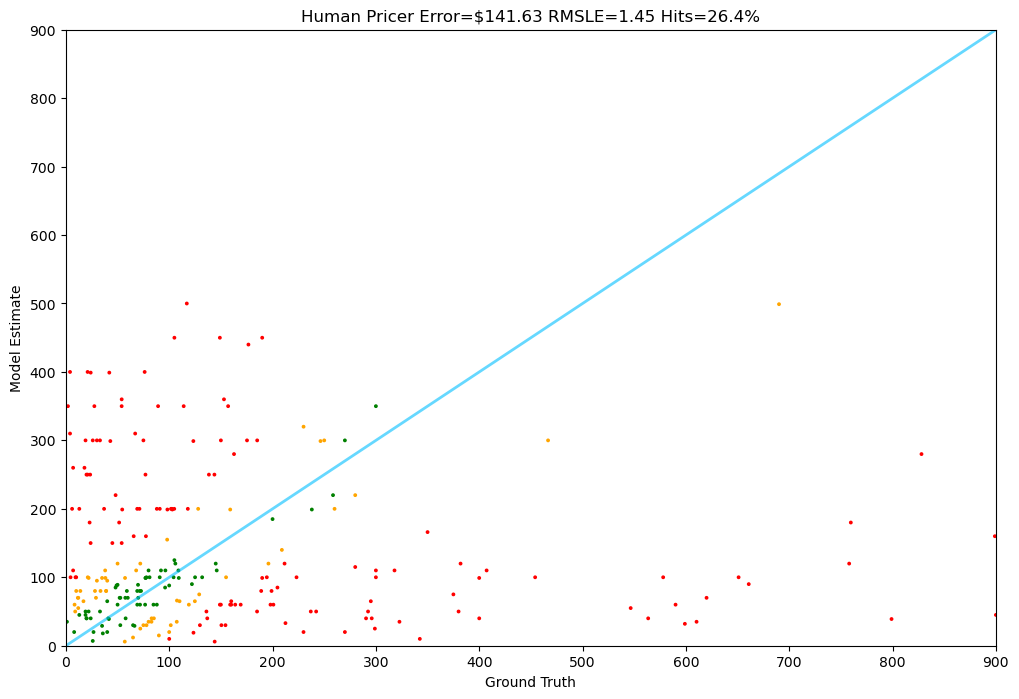

In [11]:
Tester.test(human_pricer, test)

## First, the humble but mighty GPT-4o-mini

It's called mini, but it packs a punch.

In [12]:
# First let's work on a good prompt for a Frontier model
# Notice that I'm removing the " to the nearest dollar"
# When we train our own models, we'll need to make the problem as easy as possible, 
# but a Frontier model needs no such simplification.

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [16]:
# The function for gpt-4o-mini

def gpt_4o_mini(item):
    response = openai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

1: Guess: $199.00 Truth: $195.99 Error: $3.01 SLE: 0.00 Item: Vertex Ultraphonix MKII Overdrive
2: Guess: $29.99 Truth: $38.99 Error: $9.00 SLE: 0.07 Item: Wood Grip | Universal Conversion Kit | B...
3: Guess: $5.99 Truth: $1.00 Error: $4.99 SLE: 1.57 Item: Traxxas 1726 Antenna, Tube, Vinyl Antenn...
4: Guess: $299.99 Truth: $299.99 Error: $0.00 SLE: 0.00 Item: Jackson JS Series Dinky Arch Top JS32Q D...
5: Guess: $350.00 Truth: $374.99 Error: $24.99 SLE: 0.00 Item: TOTO LPT754.8#01 Whitney Lavatory and Pe...
6: Guess: $25.99 Truth: $64.95 Error: $38.96 SLE: 0.80 Item: Sliding Glass Patio Door Handle Set, Mor...
7: Guess: $499.99 Truth: $279.99 Error: $220.00 SLE: 0.33 Item: First Watch / Homak 6-Gun Security Cabin...
8: Guess: $150.00 Truth: $131.85 Error: $18.15 SLE: 0.02 Item: WEN 3921 16-inch Two-Direction Variable ...
9: Guess: $199.99 Truth: $185.11 Error: $14.88 SLE: 0.01 Item: Tropwellhouse Crytal Ceiling Fan with Li...
10: Guess: $47.99 Truth: $72.69 Error: $24.70 SLE: 0.17 It

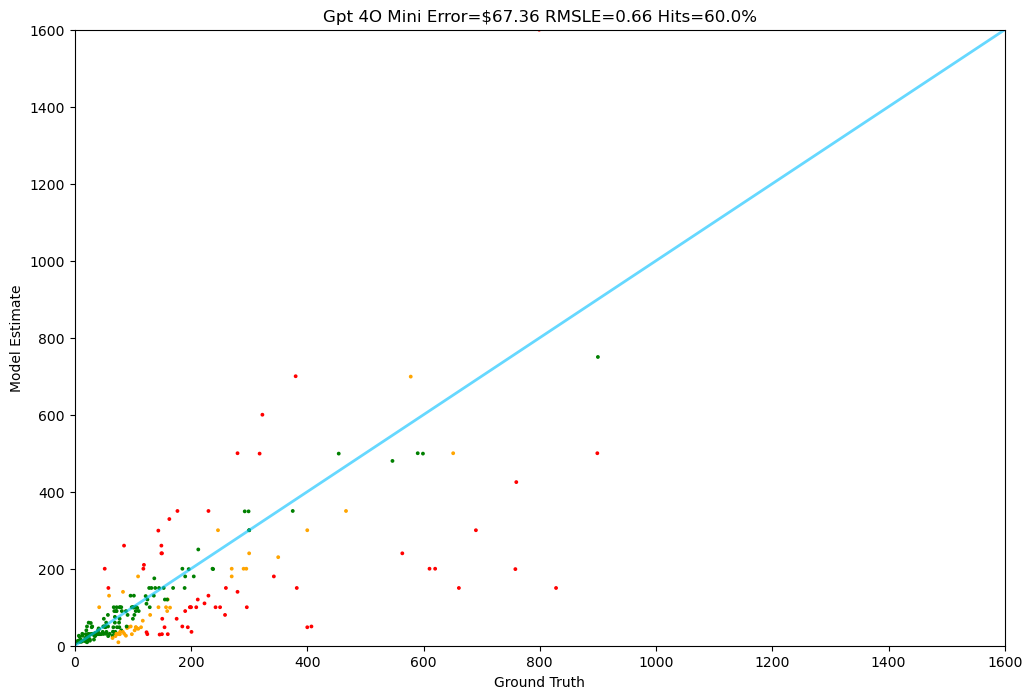

In [18]:
Tester.test(gpt_4o_mini, test)

In [19]:
def gpt_4o_frontier(item):
    response = openai.chat.completions.create(
        model="gpt-4o-2024-08-06", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

1: Guess: $199.99 Truth: $195.99 Error: $4.00 SLE: 0.00 Item: Vertex Ultraphonix MKII Overdrive
2: Guess: $35.99 Truth: $38.99 Error: $3.00 SLE: 0.01 Item: Wood Grip | Universal Conversion Kit | B...
3: Guess: $5.00 Truth: $1.00 Error: $4.00 SLE: 1.21 Item: Traxxas 1726 Antenna, Tube, Vinyl Antenn...
4: Guess: $349.99 Truth: $299.99 Error: $50.00 SLE: 0.02 Item: Jackson JS Series Dinky Arch Top JS32Q D...
5: Guess: $500.00 Truth: $374.99 Error: $125.01 SLE: 0.08 Item: TOTO LPT754.8#01 Whitney Lavatory and Pe...
6: Guess: $25.99 Truth: $64.95 Error: $38.96 SLE: 0.80 Item: Sliding Glass Patio Door Handle Set, Mor...
7: Guess: $250.00 Truth: $279.99 Error: $29.99 SLE: 0.01 Item: First Watch / Homak 6-Gun Security Cabin...
8: Guess: $120.00 Truth: $131.85 Error: $11.85 SLE: 0.01 Item: WEN 3921 16-inch Two-Direction Variable ...
9: Guess: $262.47 Truth: $185.11 Error: $77.36 SLE: 0.12 Item: Tropwellhouse Crytal Ceiling Fan with Li...
10: Guess: $80.00 Truth: $72.69 Error: $7.31 SLE: 0.01 It

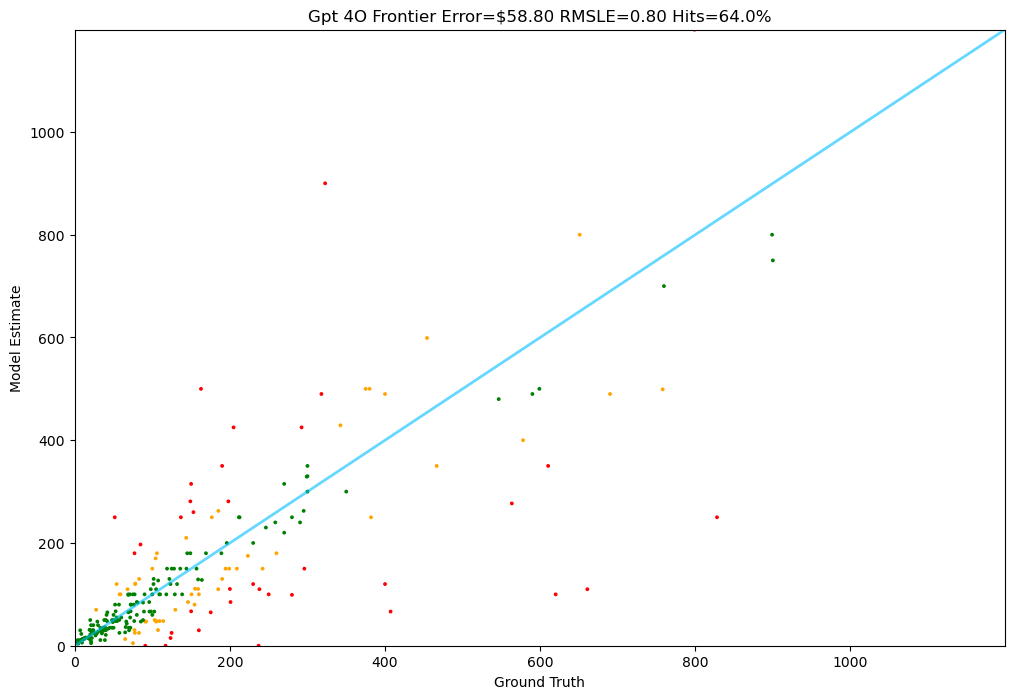

In [ ]:

Tester.test(gpt_4o_frontier, test)

In [ ]:
def claude_3_point_5_sonnet(item):
    messages = messages_for(item)
    system_message = messages[0]['content']
    messages = messages[1:]
    response = claude.messages.create(
        model="claude-3-5-sonnet-20240620",
        max_tokens=5,
        system=system_message,
        messages=messages
    )
    reply = response.content[0].text
    return get_price(reply)

In [ ]:


Tester.test(claude_3_point_5_sonnet, test)